     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.64.1 which is incompatible.
datasets 4.0.0 requires tqdm>=4.66.3, but you have tqdm 4.64.1 which is incompatible.
Device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 177MB/s] 


Training AE baseline...
[AE] Ep1 Train:0.037559 Val:0.015869
[AE] Ep2 Train:0.013804 Val:0.012531
[AE] Ep3 Train:0.011492 Val:0.011024
[AE] Ep4 Train:0.010334 Val:0.010068
[AE] Ep5 Train:0.009570 Val:0.009585
[AE] Ep6 Train:0.009019 Val:0.009030
[AE] Ep7 Train:0.008592 Val:0.008698
[AE] Ep8 Train:0.008369 Val:0.008467
[AE] Ep9 Train:0.008052 Val:0.008266
[AE] Ep10 Train:0.007840 Val:0.008070
[AE] Ep11 Train:0.007676 Val:0.007993
[AE] Ep12 Train:0.007534 Val:0.007822
[AE] Ep13 Train:0.007433 Val:0.007659
[AE] Ep14 Train:0.007273 Val:0.007745
[AE] Ep15 Train:0.007181 Val:0.007519
[AE] Ep16 Train:0.007108 Val:0.007475
[AE] Ep17 Train:0.007020 Val:0.007368
[AE] Ep18 Train:0.006947 Val:0.007279
[AE] Ep19 Train:0.006880 Val:0.007242
[AE] Ep20 Train:0.006808 Val:0.007233
Training VAE baseline...
[VAE] Ep1 Train:0.038750 Recon:0.034712 KL:4.038815 Val:0.018536
[VAE] Ep2 Train:0.015779 Recon:0.013253 KL:2.525611 Val:0.014707
[VAE] Ep3 Train:0.013688 Recon:0.011252 KL:2.435945 Val:0.013152
[VAE]

/tmp/ipython-input-3733326918.py:391: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


VAE: MSE 0.0076840720139443874 FID 159.0719777983779 IS 3.444786787033081
Evaluating ARINDAE...
ARINDAE: MSE 0.007991581223905087 FID 187.7648868424754 IS 3.3155226707458496


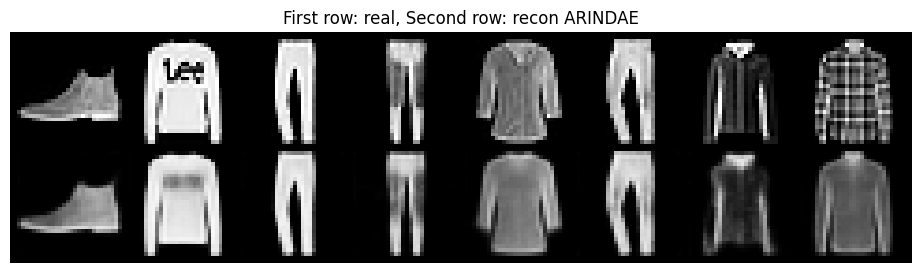

Saved metrics to results_metrics.json


In [3]:

!pip install torch torchvision tqdm==4.64.1 --quiet

import os, math, random, time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models, utils

from torch.utils.data import DataLoader, random_split
from sklearn.metrics import pairwise
from scipy import linalg

# ----------------------------
# Config / Hyperparameters
# ----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH = 128
EPOCHS = 20           # increase for final experiments
LATENT_DIM = 32
LR = 1e-3
K_RECALL = 3          # active recall steps
KL_WEIGHT = 1e-3
CONSISTENCY_WEIGHT = 1.0
MASK_RATIO = 0.25     # fraction of pixels masked during training for ARINDAE
MODEL_DIR = "models_arindae"
os.makedirs(MODEL_DIR, exist_ok=True)
print("Device:", DEVICE)

# ----------------------------
# Data: Fashion-MNIST
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),        # [0,1]
])

train_full = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_set   = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

# small validation split
train_size = int(0.9 * len(train_full))
val_size   = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ----------------------------
# Utility: showing images
# ----------------------------
def show_grid(tensor_images, nrow=8, title=None):
    grid = utils.make_grid(tensor_images.cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=(12,3))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# ----------------------------
# Models (2D convs for images)
# ----------------------------
class HybridEncoder2D(nn.Module):
    def __init__(self, in_ch=1, latent_dim=LATENT_DIM):
        super().__init__()
        # VGG-like path
        self.vgg = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # 28 -> 14
        )
        # ResNet-like small block
        self.res1 = nn.Conv2d(in_ch, 32, 3, padding=1)
        self.res2 = nn.Conv2d(32, 32, 3, padding=1)

        # compute flatten sizes
        with torch.no_grad():
            dummy = torch.zeros(1, in_ch, 28, 28)
            v_flat = self.vgg(dummy).view(1,-1).shape[1]
            r = F.relu(self.res1(dummy)); r = self.res2(r); r_flat = r.view(1,-1).shape[1]
        self.v_flat = v_flat; self.r_flat = r_flat

        self.fc = nn.Linear(v_flat + r_flat, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        v = self.vgg(x).view(x.size(0), -1)
        r = F.relu(self.res1(x))
        r = self.res2(r)

        skip = x.repeat(1, 32, 1, 1)
        r = r + skip
        r = r.view(x.size(0), -1)
        h = F.relu(self.fc(torch.cat([v, r], dim=1)))
        mu = self.fc_mu(h); logvar = torch.clamp(self.fc_logvar(h), -10, 10)
        return mu, logvar

class Decoder2D(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        # expand to 7x7 map then convtranspose to 28x28
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), #7->14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), #14->28
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()  # output in [0,1]
        )
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0.)

    def forward(self, z):
        out = self.fc(z).view(-1, 128, 7, 7)
        out = self.deconv(out)
        return out

# AE baseline (deterministic)
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = HybridEncoder2D(in_ch=1, latent_dim=LATENT_DIM)
        # In AE, I will use mu from encoder as deterministic z
        self.decoder = Decoder2D(latent_dim=LATENT_DIM)
    def forward(self, x):
        mu, _ = self.encoder(x)
        xhat = self.decoder(mu)
        return xhat, mu

# VAE baseline
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.encoder = HybridEncoder2D(in_ch=1, latent_dim=latent_dim)
        self.decoder = Decoder2D(latent_dim=latent_dim)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        xhat = self.decoder(z)
        return xhat, mu, logvar

# ARINDAE (Active Recall + stochastic)
class ARINDAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, k_recall=K_RECALL, mask_ratio=MASK_RATIO, use_vae=True):
        super().__init__()
        self.encoder = HybridEncoder2D(in_ch=1, latent_dim=latent_dim)
        self.decoder = Decoder2D(latent_dim=latent_dim)
        self.k = k_recall
        self.mask_ratio = mask_ratio
        self.use_vae = use_vae
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def random_mask(self, x):
        # x: (B,1,28,28); mask pixels randomly
        B, C, H, W = x.shape
        mask = (torch.rand(B, 1, H, W, device=x.device) > self.mask_ratio).float()
        return x * mask
    def forward(self, x):
        recs = []
        # mask input to simulate recall/partial prompt
        x_mask = self.random_mask(x)
        mu, logvar = self.encoder(x_mask)
        if self.use_vae:
            z = self.reparam(mu, logvar)
        else:
            z = mu
        rec = self.decoder(z)
        recs.append(rec)
        # recall loop: re-encode previous reconstruction
        for i in range(1, self.k):
            mu_r, logvar_r = self.encoder(recs[-1])
            if self.use_vae:
                z = self.reparam(mu_r, logvar_r)
            else:
                z = mu_r
            rec = self.decoder(z)
            recs.append(rec)
            mu, logvar = mu_r, logvar_r
        return recs, mu, logvar

# ----------------------------
# Losses & training utilities
# ----------------------------
def vae_loss(xhat, x, mu, logvar, recon_weight=1.0, kl_weight=KL_WEIGHT):
    recon = F.mse_loss(xhat, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl_weight * kld, recon, kld

def arindae_loss(recs, x, mu, logvar, recon_weight=1.0, cons_weight=CONSISTENCY_WEIGHT, kl_weight=KL_WEIGHT):
    # recs: list of K reconstructions (each (B,1,28,28))
    rec1 = recs[0]
    recon = F.mse_loss(rec1, x, reduction='mean')
    # recall consistency: MSE between consecutive recalls
    cons = 0.0
    for i in range(len(recs)-1):
        cons = cons + F.mse_loss(recs[i], recs[i+1], reduction='mean')
    cons = cons / (len(recs)-1) if len(recs) > 1 else torch.tensor(0.0, device=x.device)
    if mu is None or logvar is None:
        kld = torch.tensor(0.0, device=x.device)
    else:
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_weight * recon + cons_weight * cons + kl_weight * kld
    return total, recon, cons, kld

# ----------------------------
# Trainer functions
# ----------------------------
def train_ae(model, epochs=EPOCHS):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
    best_val = 1e9; patience=8; wait=0
    for ep in range(1, epochs+1):
        model.train()
        tot=0; n=0
        for xb, _ in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            xhat, _ = model(xb)
            loss = F.mse_loss(xhat, xb, reduction='mean')
            loss.backward(); opt.step()
            tot += loss.item()*xb.size(0); n += xb.size(0)
        train_loss = tot/n
        # val
        model.eval(); vt=0; vn=0
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(DEVICE)
                xhat, _ = model(xb)
                l = F.mse_loss(xhat, xb, reduction='mean')
                vt += l.item()*xb.size(0); vn += xb.size(0)
        val_loss = vt/vn
        print(f"[AE] Ep{ep} Train:{train_loss:.6f} Val:{val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss; wait=0; torch.save(model.state_dict(), os.path.join(MODEL_DIR,"ae_best.pt"))
        else:
            wait += 1
            if wait >= patience:
                print("[AE] Early stopping")
                break
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR,"ae_best.pt")))
    return model

def train_vae(model, epochs=EPOCHS):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
    best_val = 1e9; patience=8; wait=0
    for ep in range(1, epochs+1):
        model.train()
        tot=0; n=0; rtot=0; ktot=0
        for xb, _ in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            xhat, mu, logvar = model(xb)
            loss, recon, kld = vae_loss(xhat, xb, mu, logvar)
            loss.backward(); opt.step()
            tot += loss.item()*xb.size(0); rtot += recon.item()*xb.size(0); ktot += kld.item()*xb.size(0); n += xb.size(0)
        train_loss = tot/n
        train_recon = rtot/n; train_kld = ktot/n
        # val
        model.eval(); vt=0; vn=0
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(DEVICE)
                xhat, mu, logvar = model(xb)
                l, _, _ = vae_loss(xhat, xb, mu, logvar)
                vt += l.item()*xb.size(0); vn += xb.size(0)
        val_loss = vt/vn
        print(f"[VAE] Ep{ep} Train:{train_loss:.6f} Recon:{train_recon:.6f} KL:{train_kld:.6f} Val:{val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss; wait=0; torch.save(model.state_dict(), os.path.join(MODEL_DIR,"vae_best.pt"))
        else:
            wait += 1
            if wait >= patience:
                print("[VAE] Early stopping")
                break
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR,"vae_best.pt")))
    return model

def train_arindae(model, epochs=EPOCHS):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
    best_val = 1e9; patience=8; wait=0
    for ep in range(1, epochs+1):
        model.train()
        tot=0; n=0; rtot=0; ctot=0; ktot=0
        for xb, _ in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            recs, mu, logvar = model(xb)
            loss, recon, cons, kld = arindae_loss(recs, xb, mu, logvar)
            loss.backward(); opt.step()
            tot += loss.item()*xb.size(0); rtot += recon.item()*xb.size(0); ctot += cons.item()*xb.size(0); ktot += kld.item()*xb.size(0); n += xb.size(0)
        train_loss = tot/n; train_recon = rtot/n; train_cons = ctot/n; train_kld = ktot/n
        # val
        model.eval(); vt=0; vn=0
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(DEVICE)
                recs, mu, logvar = model(xb)
                l, recon, cons, kld = arindae_loss(recs, xb, mu, logvar)
                vt += l.item()*xb.size(0); vn += xb.size(0)
        val_loss = vt/vn
        print(f"[ARINDAE] Ep{ep} Train:{train_loss:.6f} Rec:{train_recon:.6f} Cons:{train_cons:.6f} KL:{train_kld:.6f} Val:{val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss; wait=0; torch.save(model.state_dict(), os.path.join(MODEL_DIR,"arindae_best.pt"))
        else:
            wait += 1
            if wait >= patience:
                print("[ARINDAE] Early stopping")
                break
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR,"arindae_best.pt")))
    return model

# ----------------------------
# Utility: FID and IS Helpers
# ----------------------------
# Using torchvision Inception v3 pretrained
inception = models.inception_v3(pretrained=True, transform_input=False).to(DEVICE)
inception.eval()

# get pool3 activations (2048-d) for inputs resized to 299x299
def get_inception_activations(loader_or_tensor, batch_size=64):
    act_list = []
    softmax_list = []
    with torch.no_grad():
        if isinstance(loader_or_tensor, torch.utils.data.DataLoader) or isinstance(loader_or_tensor, list):
            data_iter = loader_or_tensor
        else:
            # assume tensor NCHW
            dataset = torch.utils.data.TensorDataset(loader_or_tensor)
            data_iter = DataLoader(dataset, batch_size=batch_size)
        for batch in data_iter:
            if isinstance(batch, (list, tuple)):
                imgs = batch[0]
            else:
                imgs = batch[0]
            imgs = imgs.to(DEVICE)
            # resize to 299 and replicate channels to 3
            imgs3 = imgs.repeat(1,3,1,1)
            imgs_resized = F.interpolate(imgs3, size=(299,299), mode='bilinear', align_corners=False)

            out = inception.forward(imgs_resized)

            logits = out
            probs = F.softmax(logits, dim=1)
            softmax_list.append(probs.cpu().numpy())
            # using logits as proxy features
            act_list.append(logits.cpu().numpy())
    acts = np.concatenate(act_list, axis=0)
    probs = np.concatenate(softmax_list, axis=0)
    return acts, probs

def compute_fid_from_acts(act1, act2):
    # act1, act2: (N, D) numpy arrays (we'll use logits as proxy)
    mu1 = np.mean(act1, axis=0)
    mu2 = np.mean(act2, axis=0)
    sigma1 = np.cov(act1, rowvar=False)
    sigma2 = np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return float(np.real(fid))

def inception_score_from_probs(probs, splits=10):
    # probs shape (N, num_classes)
    N = probs.shape[0]
    split_scores = []
    for k in range(splits):
        part = probs[k * (N//splits):(k+1)*(N//splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i]
            scores.append(scipy_stats_kl(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

def scipy_stats_kl(p, q):
    # KL divergence between categorical distributions
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return np.sum(p * (np.log(p) - np.log(q)))

# ----------------------------
# Evaluate models (MSE + FID + IS)
# ----------------------------
import numpy as np
def evaluate_generation(model, num_samples=1000):
    # generate reconstructions for test set
    model.eval()
    recons = []
    reals = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(DEVICE)
            if isinstance(model, AE):
                xhat, _ = model(xb)
            elif isinstance(model, VAE):
                xhat, mu, logvar = model(xb)
            else: # ARINDAE
                recs, mu, logvar = model(xb)
                xhat = recs[0]  # first reconstruction
            recons.append(xhat.cpu())
            reals.append(xb.cpu())
            if sum([r.shape[0] for r in recons]) >= num_samples:
                break
    recons = torch.cat(recons, dim=0)[:num_samples]
    reals = torch.cat(reals, dim=0)[:num_samples]
    # compute MSE
    mse = F.mse_loss(recons, reals, reduction='mean').item()
    # FID/IS via get_inception_activations
    acts_recon, probs_recon = get_inception_activations(recons, batch_size=64)
    acts_real, probs_real = get_inception_activations(reals, batch_size=64)
    fid = compute_fid_from_acts(acts_real, acts_recon)

    py = np.mean(probs_recon, axis=0, keepdims=True)
    kl = probs_recon * (np.log(np.clip(probs_recon,1e-10,None)) - np.log(np.clip(py,1e-10,None)))
    kl_sum = np.sum(np.sum(kl, axis=1))
    is_score = float(np.exp(kl_sum / probs_recon.shape[0]))
    return mse, fid, is_score, reals, recons

# ----------------------------
# Run experiments
# ----------------------------
# 1) Train AE baseline
ae = AE().to(DEVICE)
print("Training AE baseline...")
ae = train_ae(ae, epochs=EPOCHS)
torch.save(ae.state_dict(), os.path.join(MODEL_DIR, "ae_final.pth"))

# 2) Train VAE baseline
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
print("Training VAE baseline...")
vae = train_vae(vae, epochs=EPOCHS)
torch.save(vae.state_dict(), os.path.join(MODEL_DIR, "vae_final.pth"))

# 3) Train ARINDAE (our model)
arindae = ARINDAE(latent_dim=LATENT_DIM, k_recall=K_RECALL, mask_ratio=MASK_RATIO, use_vae=True).to(DEVICE)
print("Training ARINDAE model...")
arindae = train_arindae(arindae, epochs=EPOCHS)
torch.save(arindae.state_dict(), os.path.join(MODEL_DIR, "arindae_final.pth"))

# ----------------------------
# Evaluate models
# ----------------------------
print("Evaluating AE...")
mse_ae, fid_ae, is_ae, reals_ae, recons_ae = evaluate_generation(ae, num_samples=1024)
print("AE: MSE", mse_ae, "FID", fid_ae, "IS", is_ae)

print("Evaluating VAE...")
mse_vae, fid_vae, is_vae, reals_vae, recons_vae = evaluate_generation(vae, num_samples=1024)
print("VAE: MSE", mse_vae, "FID", fid_vae, "IS", is_vae)

print("Evaluating ARINDAE...")
mse_ar, fid_ar, is_ar, reals_ar, recons_ar = evaluate_generation(arindae, num_samples=1024)
print("ARINDAE: MSE", mse_ar, "FID", fid_ar, "IS", is_ar)

# show reconstructions
show_grid(torch.cat([reals_ar[:8], recons_ar[:8]]), nrow=8, title="First row: real, Second row: recon ARINDAE")

# Save metrics
metrics = {
    "AE": {"mse":mse_ae, "fid":fid_ae, "is":is_ae},
    "VAE":{"mse":mse_vae, "fid":fid_vae, "is":is_vae},
    "ARINDAE":{"mse":mse_ar, "fid":fid_ar, "is":is_ar}
}
import json
with open("results_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to results_metrics.json")


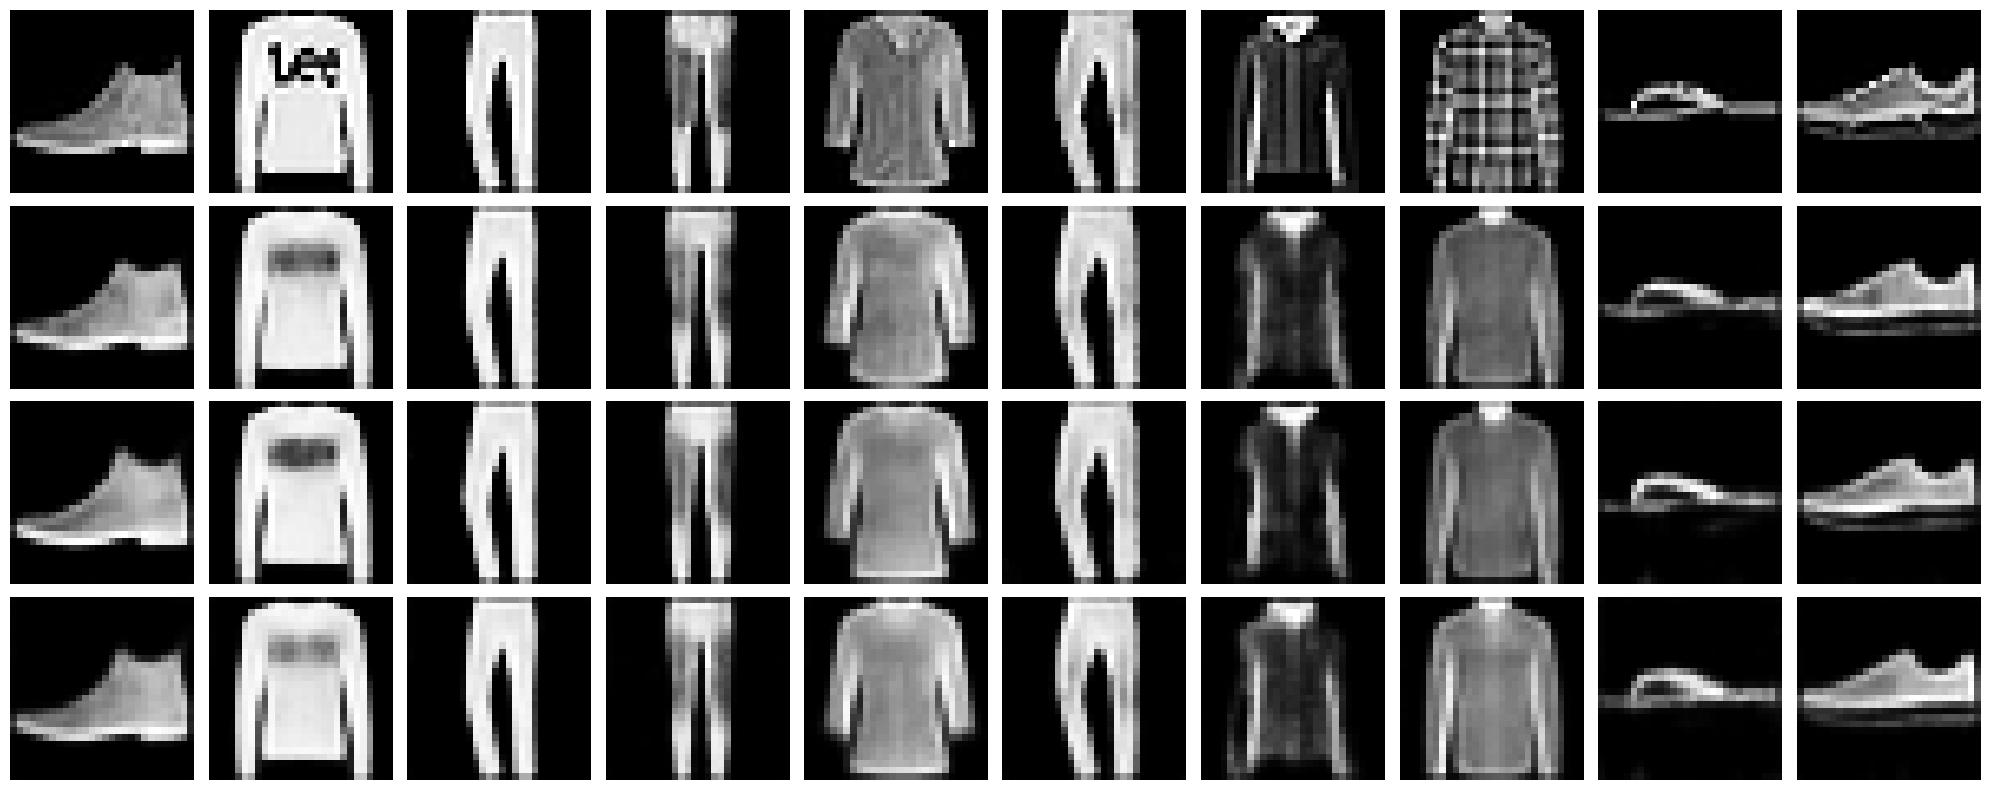

In [4]:
import matplotlib.pyplot as plt

def compare_models(models, test_loader, n=10):
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(DEVICE)[:n]

    fig, axes = plt.subplots(len(models)+1, n, figsize=(n*2, (len(models)+1)*2))

    # Original images
    for i in range(n):
        axes[0, i].imshow(imgs[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
    axes[0, 0].set_ylabel("Original", fontsize=12)

    # Reconstructions from each model
    for row, (name, model) in enumerate(models.items(), start=1):
        # Handle different return types of models
        if isinstance(model, AE):
            recon, _ = model(imgs)
        elif isinstance(model, VAE):
            recon, _, _ = model(imgs)
        else: # ARINDAE
            recs, _, _ = model(imgs)
            recon = recs[0] # Use the first reconstruction

        for i in range(n):
            axes[row, i].imshow(recon[i].cpu().detach().squeeze(), cmap="gray")
            axes[row, i].axis("off")
        axes[row, 0].set_ylabel(name, fontsize=12)

    plt.tight_layout()
    plt.show()

models = {"AE": ae, "VAE": vae, "ARINDAE": arindae}
compare_models(models, test_loader)

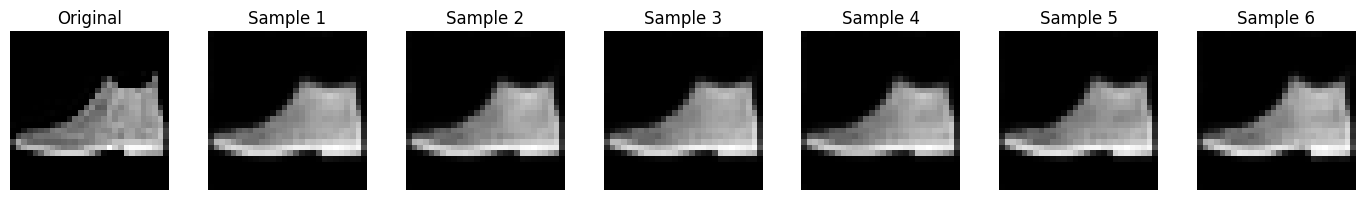

In [ ]:
def uncertainty_visualization(model, test_loader, img_idx=0, n_samples=6):
    imgs, _ = next(iter(test_loader))
    img = imgs[img_idx:img_idx+1].to(DEVICE)

    fig, axes = plt.subplots(1, n_samples+1, figsize=((n_samples+1)*2, 2))

    # Original
    axes[0].imshow(img.cpu().squeeze(), cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Multiple stochastic reconstructions
    for i in range(n_samples):
        recon, _, _ = model(img)
        axes[i+1].imshow(recon[0].cpu().detach().squeeze(), cmap="gray")
        axes[i+1].set_title(f"Sample {i+1}")
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()

uncertainty_visualization(arindae, test_loader, img_idx=0)

In [5]:
import pandas as pd

results = []
for name, model in models.items():

    mse, fid, is_score, _, _ = evaluate_generation(model, num_samples=1024)

    is_mean = is_score

    is_std = float('nan')
    results.append([name, mse, fid, is_mean, is_std])

df = pd.DataFrame(results, columns=["Model", "MSE ↓", "FID ↓", "IS ↑ (mean)", "IS Std"])
print(df)

/tmp/ipython-input-3733326918.py:391: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


     Model     MSE ↓       FID ↓  IS ↑ (mean)  IS Std
0       AE  0.007165  147.182558     3.534680     NaN
1      VAE  0.007676  158.937129     3.473739     NaN
2  ARINDAE  0.008031  187.293210     3.299657     NaN


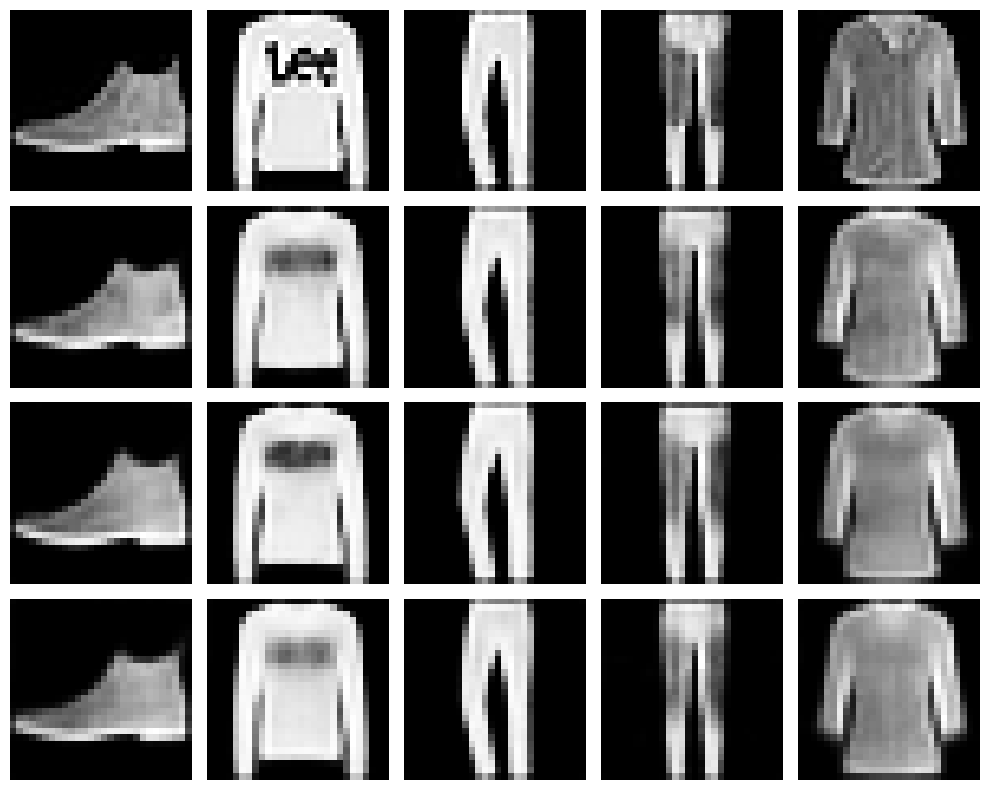

In [8]:
import matplotlib.pyplot as plt
import os

def compare_models(models, test_loader, n_images=5, n_samples=1, save_path=None):

    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(DEVICE)[:n_images]

    n_models = len(models)

    fig, axes = plt.subplots(n_models + 1, n_images, figsize=(n_images * 2, (n_models + 1) * 2))

    # First row: original images
    for i in range(n_images):
        axes[0, i].imshow(imgs[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
    axes[0, 0].set_ylabel("Original", fontsize=12)

    # Rows for each model
    for row_idx, (name, model) in enumerate(models.items(), start=1):
        for i in range(n_images):
            if name == "ARINDAE":

                reconstructions, _, _ = model(imgs[i:i+1])
                recon = reconstructions[0]
            elif name == "VAE":
                recon, _, _ = model(imgs[i:i+1])
            else:  # AE
                recon, _ = model(imgs[i:i+1])

            axes[row_idx, i].imshow(recon.cpu().detach().squeeze(), cmap="gray")
            axes[row_idx, i].axis("off")

        axes[row_idx, 0].set_ylabel(name, fontsize=12)

    plt.tight_layout()

    if save_path:
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Example usage:
models = {"AE": ae, "VAE": vae, "ARINDAE": arindae}
compare_models(models, test_loader, n_images=5, save_path="images/model_comparison.png")